# STUDENTS STUDY
- looks at all student data set, emphasis on gaming motivation and personality
- Heat map of gamer motivation and personality vs y-vals
- Generates csv of r, r^2, p-val, and std-dev**
- pie chart representation of demographic data

### Data import + definitions, DNE

In [1]:
## set up
import io
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
from sklearn.model_selection import train_test_split
import helper_functions.spreadsheet_specific_helpers as helper
import seaborn as sns
import scipy.stats as stats


SHEETURL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1sptWDnGOyRcEyCHFYhyC8Y_zXGGM5jMpePRVusoSkFs/"
    "edit?resourcekey=&gid=1530912831#gid=1530912831"
)

# format for CSV https://docs.google.com/spreadsheets/d/
# <SHEET_ID>/gviz/tq?tqx=
# out:csv&sheet=<SHEET_NAME>
SHEET_CSV_URL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1sptWDnGOyRcEyCHFYhyC8Y_zXGGM5jMpePRVusoSkFs/"
    "gviz/tq?tqx=out:csv&sheet=Altered/congregrated data"
)

# global variables for our current data purposes
Y_COLS = ["On a scale of 1 - 5 how successful do you feel you are in SEAL lab?",
            "On a scale of 1 - 5, how successful to do you feel your teammates are in SEAL lab?",
            "On a scale of 1 - 5, how successful do your peers think you are in SEAL lab?",
            "On whole, how would you rate your satisfaction in SEAL lab?"
            ]
#G:N
X_DEMO_COLS = ["What group are you primarily affiliated with in SEAL Life (shows up in SEAL clan life)?",
            "AGE (Congregated)",
            "Gender (CONGREGATED)",
            "How do you describe your sexual orientation?",	
            "Which categories best describe you?",
            "Do you have any chronic condition that substantially limit your life activities?",
            "If you have a disability, please indicate (if comfortable) the terms"
            " that best describe the condition(s)",	
            "Which economic class do you identify with?",
            "RELIGION (Congregated)"
            ]
# O:U
X_GAME_COLS = ["When playing games, I am most motivated by...",
            "I consider myself to be...",
            "When playing games, I consider myelf to be... [Introverted - Extraverted]",
            "When playing games, I am generally... [Critical - Trusting]",
            "When playing games, I prefer to be...[Spontaneous - Conscientious]",
            "When playing games, I consider myself to be...[Self conscious- even tempered]",
            "When playing games, I generally...[Prefer similarity - Am open to change]"
            ]

MOTIVATION_COLS = [
        "Beating my competitors",
        "Mastering the game",
        "Earning the most points",
        "Working with a team",
        "Feeling immersed in the story/plot"
    ]
#C, V:AJ needs to be converted to scale of 1-5
X_SEAL_COLS = ["When I use the SEAL Sudoku Sheet Tools, I feel like I am playing a game. ",
            "I consider myself to be highly experienced with the SEAL Sheet Tools.",
            "I find the Sudoku Sheet Tools to be aesthetically pleasing.",
            "I think SEAL rank reflect my work and my team's work accurately.",
            "I think SEAL leaderboard reflect my work and my team's work accurately.",
            "I think SEAL YBR reflect my work and my team's work accurately.",
            "I think SEAL VisTools reflect my work and my team's work accurately.",
            "I think SEAL RaceTrack reflect my work and my team's work accurately.",
            "I think SEAL Battle Station reflect my work and my team's work accurately.",
            "I think SEAL Command Center reflect my work and my team's work accurately.",
            "I understand what my SEAL statistics mean (Lab HP, Sheet HP, YBR Gold Delta, and Training Score).",
            "I know exactly how my actions affect my lab statistics (Lab HP, Sheet HP, YBR Gold Delta, and Training Score).",
            "Using the Sudoku Sheet Tools helps me and my team stay on track.",	
            "Using the Sudoku Sheet Tools encourages me to take risks and challenge myself.",
            "Using the Sudoku Sheet Tools makes my work in SEAL more enjoyable."
            ]
#AO:AX
X_USABILITY_COLS = ["I think that I would like to use this system frequently.",
                    "I found the system unnecessarily complex.",
                    "I thought the system was easy to use.",
                    "I think that I would need the support of a technical person to be able to use this system.",
                    "I found the various functions in this system were well integrated.",
                    "I thought there was too much inconsistency in this system.",
                    "I would imagine that most people would learn to use this system very quickly.",
                    "I found the system very cumbersome to use.",	
                    "I felt very confident using the system.",	
                    "I needed to learn a lot of things before I could get going with this system."
                ]
X_DROP_COLS = ['Timestamp',
                "Sudoku Sheet Tools are all the tools you use when actively engaging with SEAL life."
                " Like Sudoku Clan Life, Dashboard, VisTools, RaceTrack, YBR, Kanban, Rank, Battle station, Venue, etc.",
                "What groups are you affiliated with in SEAL Life?",
                "Have you ever developed software as a programmer for Sudoku Sheet Tools?",
                "What is your current age?",
                "On scale of 1-10, how confusing were the questions on this survey?",
                "If you have any, we appreciate any additional feedback on the structure and questions within the survey",
                "SUS Overall score",	
                "Learnability subscore",
                "Usability subscore"
]

In [2]:
def get_data() -> DataFrame:  # idealy we dont want to us Any, but for now
    """function to get the data from the google sheet
    raises: HTTPError: if the request fails (meaning url wrong or no inter)

    @returns: @type(DataFrame): the data from the google sheet"""

    response = requests.get(SHEET_CSV_URL)
    response.raise_for_status()  # Raise error if request fails
    df: DataFrame = pd.read_csv(io.StringIO(response.text))
    return df

data = get_data()

In [3]:
def split_xy(data, drop_cols):
    """function to split the x and y data into separate ndarrays based on
    a set of columns to be dropped

    @parameter: data @type(DataFrame): unprocessed data 
    @parameter: drop_cols @type(ndarray): array of names of columns to drop

    @returns: @type(ndarray): relevant x-values from data
    @returns: @type(ndarray): y-values from data"""

    x_data = data.drop(columns=X_DROP_COLS + Y_COLS)

    # split motivation columns:
    split_col: DataFrame = helper.split_motivation_column(x_data)
    x_data.drop('When playing games, I am most motivated by...', axis = 1, inplace = True)
    x_data = pd.concat([x_data, split_col], axis=1)

    # handle X_SEAL_COLS: map disagree - agree as 1-5
    options_map = {'Strongly disagree': 1,
                    'Disagree': 2,
                    'Neutral': 3,
                    'Agree': 4,
                    'Strongly agree': 5
                    }
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].replace(options_map)

    # handle NaN via imputation
    x_data[X_GAME_COLS[1:2]] = x_data[X_GAME_COLS[1:2]].fillna('No Response')
    x_data[X_GAME_COLS[2]] = x_data[X_GAME_COLS[2]].fillna(3)
    x_data[X_GAME_COLS[3:]] = x_data[X_GAME_COLS[3:]].fillna(3)
    x_data[X_DEMO_COLS] = x_data[X_DEMO_COLS].fillna('No Response')
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].fillna(3)
    x_data[X_USABILITY_COLS] = x_data[X_USABILITY_COLS].fillna(3)
    data[Y_COLS] = data[Y_COLS].fillna(3)

    # one-hot-encoding for categorical data (demographics, gaming)
    cat_col = x_data.select_dtypes(include=['object', 'category']).columns
    x_data = pd.get_dummies(x_data, columns = cat_col)
    y_data = data[Y_COLS]
    return x_data, y_data

In [4]:
x_data, y_data = split_xy(data, X_DROP_COLS)
print(x_data.shape)

(68, 93)


C:\Users\kelly\AppData\Local\Temp\ipykernel_13144\3841902069.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].replace(options_map)


### DATA ANALYSIS

In [6]:
### Columns for analysis
PERSONALITY = X_GAME_COLS[2:]
MOTIVATION = ['I consider myself to be..._Equally motivated by external and internal factors',
       'I consider myself to be..._Highly motivated by external rewards (e.g. leaderboard, badges, etc.)',
       'I consider myself to be..._Highly motivated by internal rewards (e.g. improving my own skills, learning)']
print(PERSONALITY)
print(MOTIVATION)
print(MOTIVATION_COLS)

# summary of data
for x in PERSONALITY:
    print(x_data[x].describe())

for x in MOTIVATION:
    print(x_data[x].describe())

for x in MOTIVATION_COLS:
    print(x_data[x].describe())


['When playing games, I consider myelf to be... [Introverted - Extraverted]', 'When playing games, I am generally... [Critical - Trusting]', 'When playing games, I prefer to be...[Spontaneous - Conscientious]', 'When playing games, I consider myself to be...[Self conscious- even tempered]', 'When playing games, I generally...[Prefer similarity - Am open to change]']
['I consider myself to be..._Equally motivated by external and internal factors', 'I consider myself to be..._Highly motivated by external rewards (e.g. leaderboard, badges, etc.)', 'I consider myself to be..._Highly motivated by internal rewards (e.g. improving my own skills, learning)']
['Beating my competitors', 'Mastering the game', 'Earning the most points', 'Working with a team', 'Feeling immersed in the story/plot']
count    68.000000
mean      2.911765
std       1.129460
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: When playing games, I consider myelf to be... 

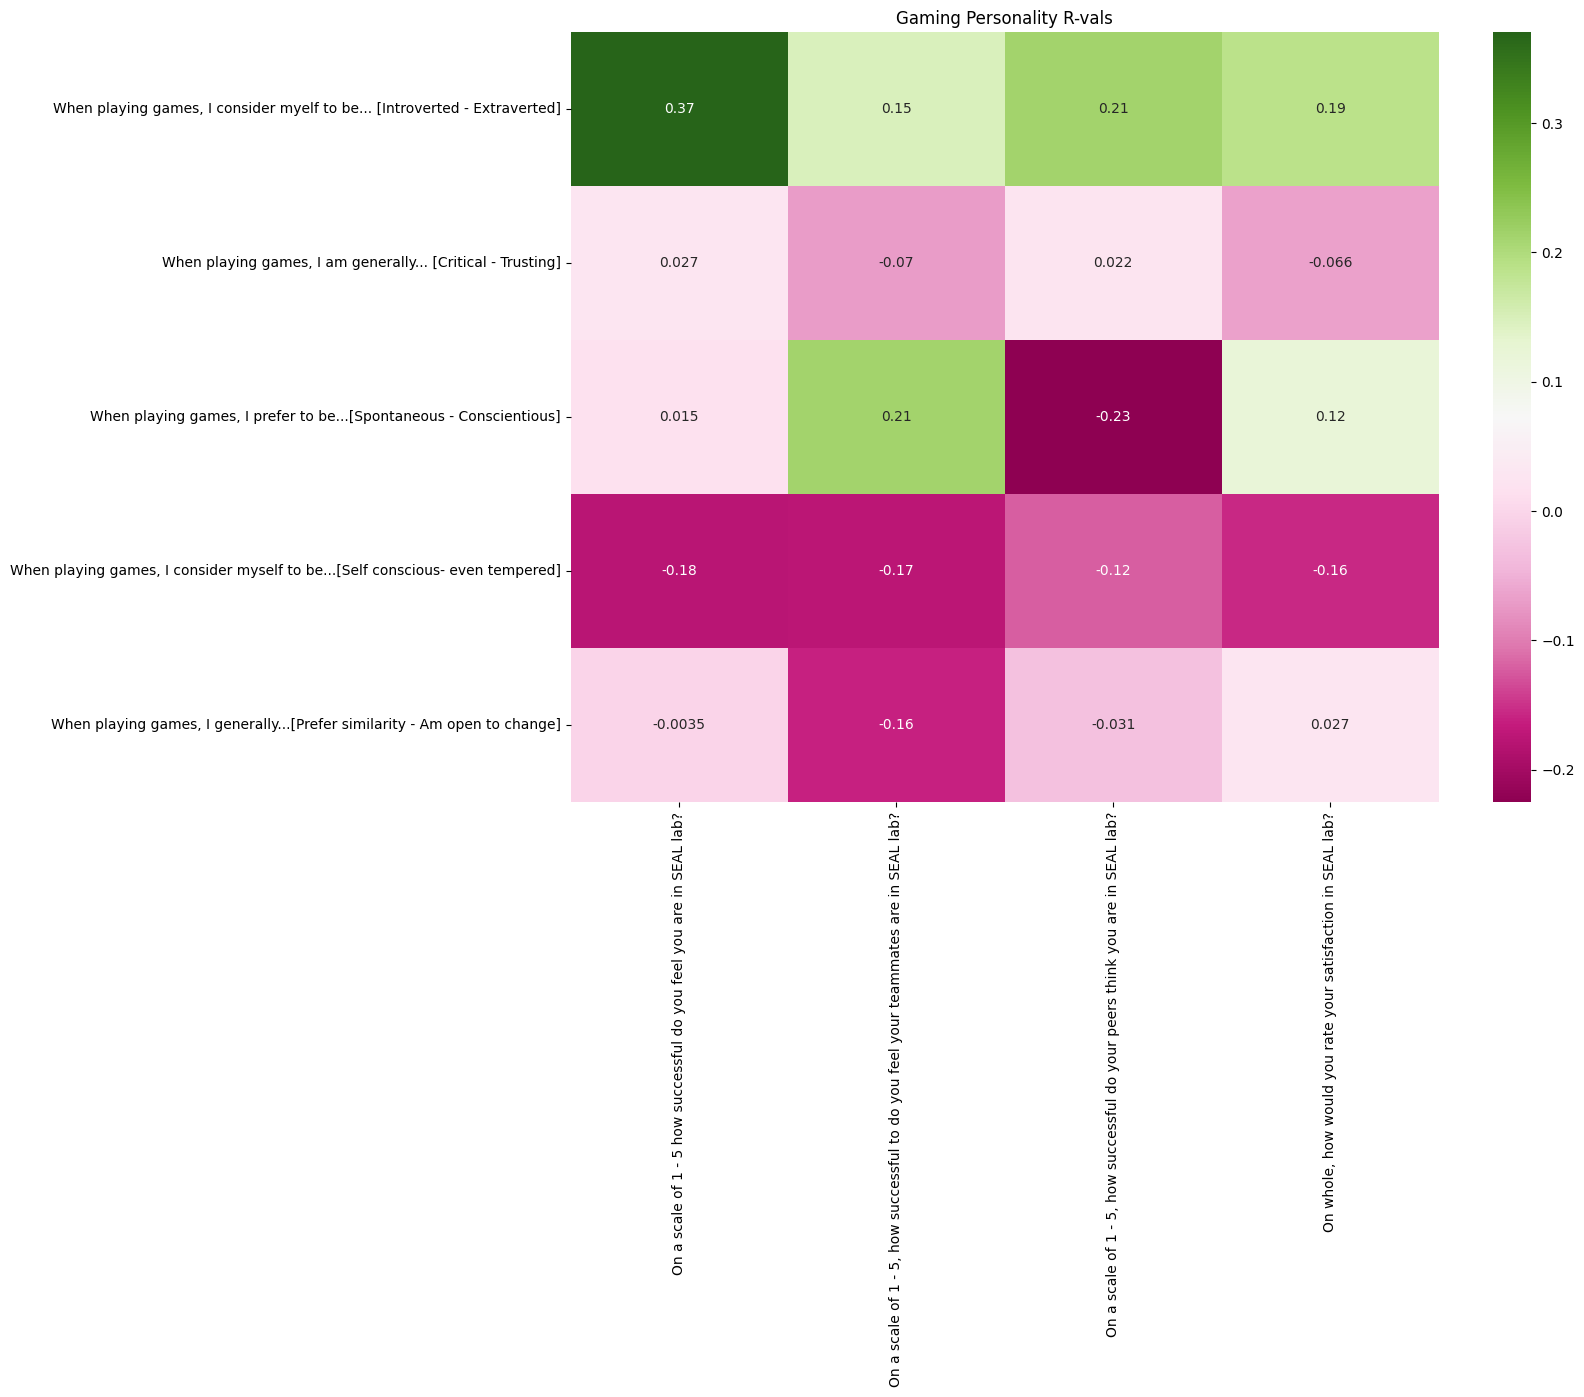

In [7]:
## personality heat map

data_combined = pd.concat([x_data[PERSONALITY], y_data], axis=1)

# Calculate the correlation matrix
correlation_matrix = data_combined.corr()
correlation_matrix = correlation_matrix.loc[PERSONALITY, Y_COLS]

# Plot the correlation matrix heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='PiYG', cbar=True, annot_kws={'size': 10}, fmt='.2g')
plt.title("Gaming Personality R-vals")
plt.savefig("Personality.png", dpi=300, bbox_inches='tight')
plt.show()


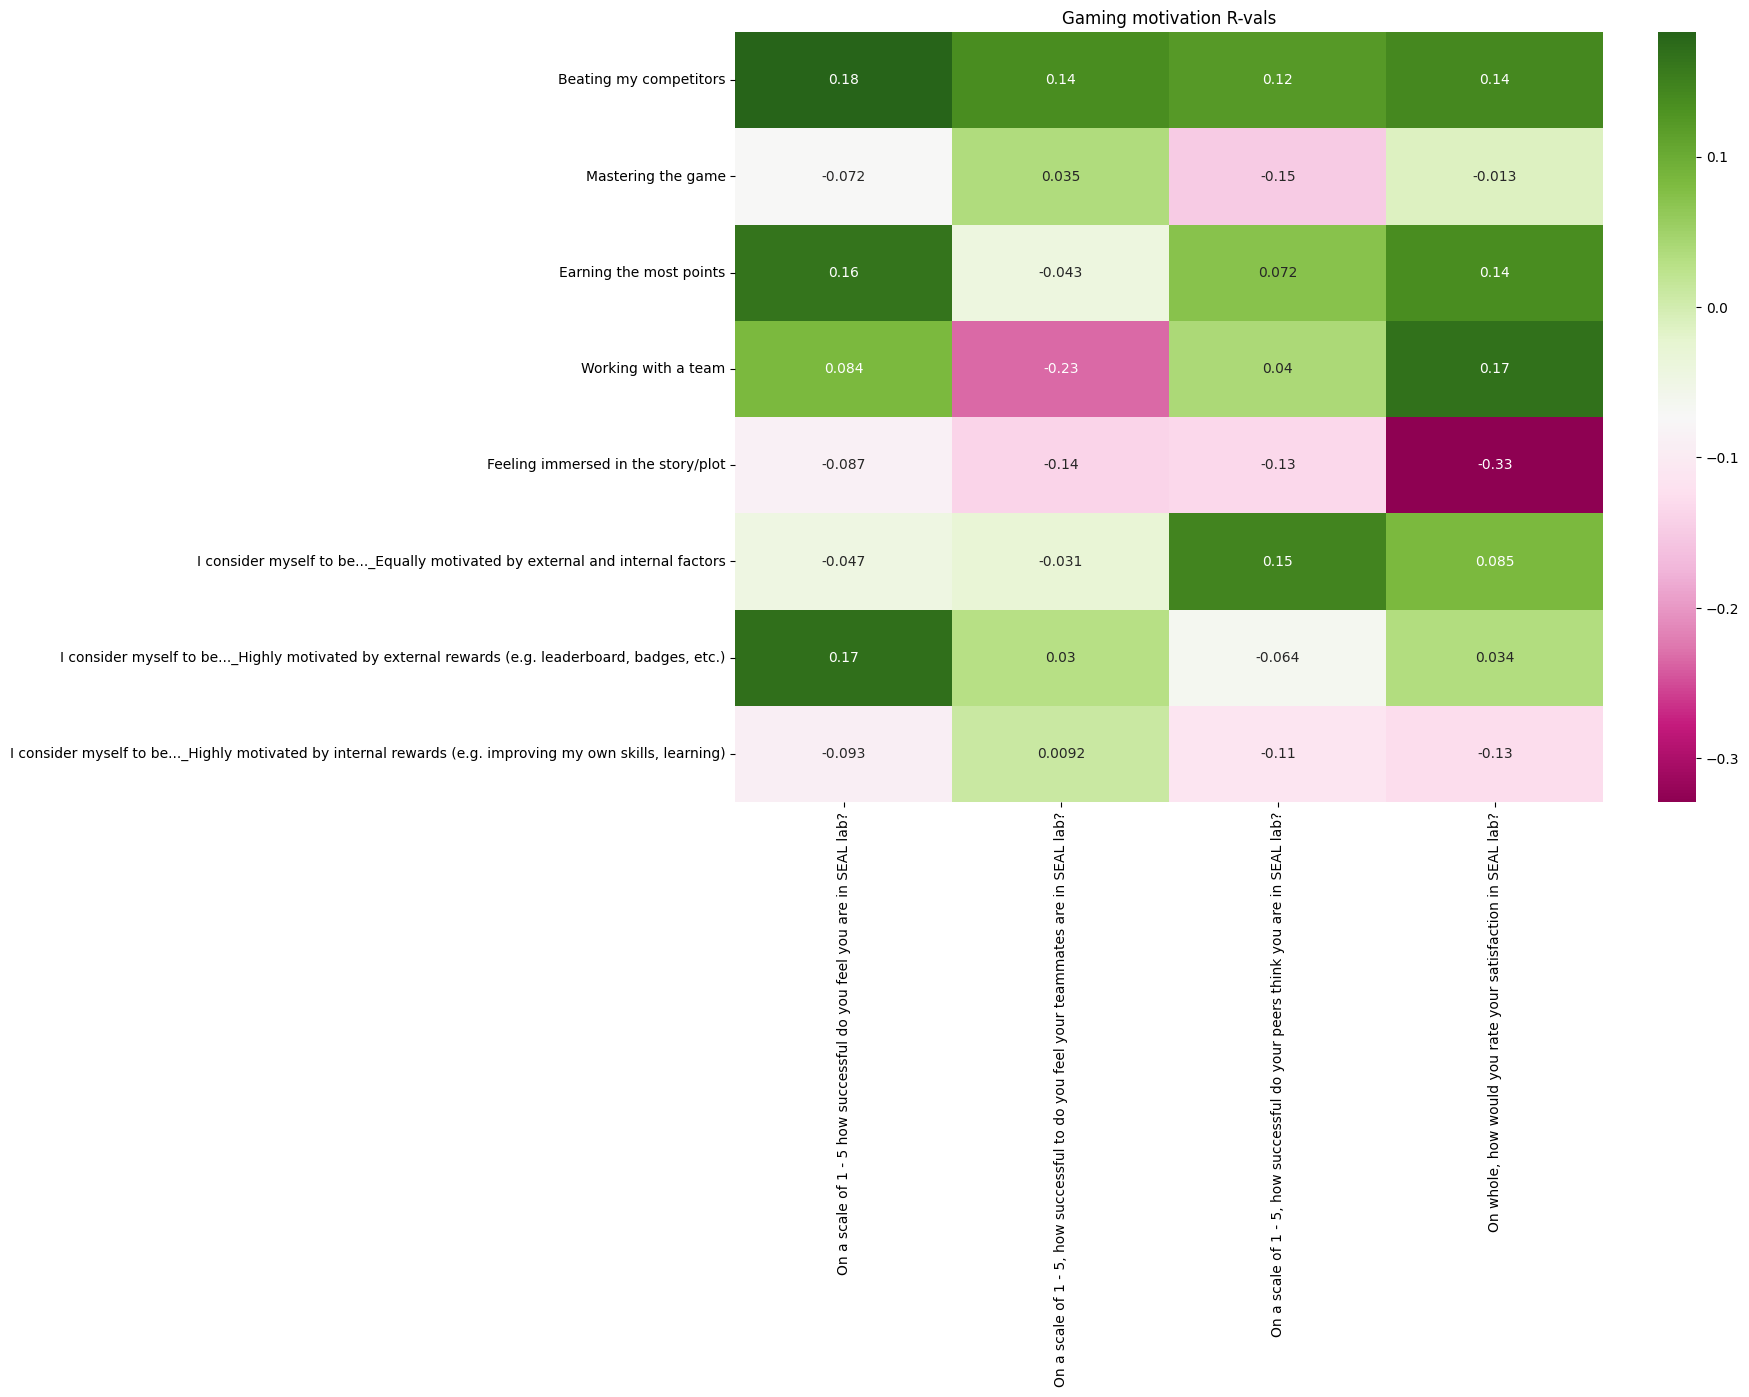

In [8]:

# Concatenate grad_x and grad_y to calculate correlations between all columns
data_combined = pd.concat([x_data[MOTIVATION], x_data[MOTIVATION_COLS], y_data], axis=1)

# Calculate the correlation matrix
correlation_matrix = data_combined.corr()
correlation_matrix = correlation_matrix.loc[MOTIVATION_COLS + MOTIVATION, Y_COLS]

# Plot the correlation matrix heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='PiYG', cbar=True, annot_kws={'size': 10}, fmt='.2g')
plt.title("Gaming motivation R-vals")
plt.savefig("Gaming_motivation.png", dpi=300, bbox_inches='tight')
plt.show()


In [9]:
### non graphical data analysis
X_COLS = PERSONALITY + MOTIVATION + MOTIVATION_COLS
print(Y_COLS)
y_names = ["personal_success", "teammate_success", "Peer_success", "satisfaction"]

for i, y_col in enumerate(Y_COLS):
    print(f"{Y_COLS[i]}")
    data_analysis = []
    for x_col in X_COLS:
        r, p_value = stats.pearsonr(x_data[x_col], y_data[y_col])
        r_2 = r ** 2
        std_dev = np.std(x_data[x_col], ddof=1)
        data_analysis.append([x_col, r, r_2, p_value, std_dev])
    stats_df = pd.DataFrame(data_analysis, columns=["X Feature", "r", "r²", "p-val", "std-dev"])
    stats_df.to_csv(f"Stats_{y_names[i]}.csv", index=False)
    print(stats_df)



['On a scale of 1 - 5 how successful do you feel you are in SEAL lab?', 'On a scale of 1 - 5, how successful to do you feel your teammates are in SEAL lab?', 'On a scale of 1 - 5, how successful do your peers think you are in SEAL lab?', 'On whole, how would you rate your satisfaction in SEAL lab?']
On a scale of 1 - 5 how successful do you feel you are in SEAL lab?
                                            X Feature         r        r²  \
0   When playing games, I consider myelf to be... ...  0.370399  0.137195   
1   When playing games, I am generally... [Critica...  0.026623  0.000709   
2   When playing games, I prefer to be...[Spontane...  0.014570  0.000212   
3   When playing games, I consider myself to be...... -0.178239  0.031769   
4   When playing games, I generally...[Prefer simi... -0.003513  0.000012   
5   I consider myself to be..._Equally motivated b... -0.046788  0.002189   
6   I consider myself to be..._Highly motivated by...  0.169157  0.028614   
7   I consider 

### Demographic analysis

In [10]:
GENDER = ['Gender (CONGREGATED)_Female',
        'Gender (CONGREGATED)_Male',
       'Gender (CONGREGATED)_No Response', 'Gender (CONGREGATED)_nb']
SEX_ORIENT = ['How do you describe your sexual orientation?_Bisexual',
       'How do you describe your sexual orientation?_Gay or lesbian',
       'How do you describe your sexual orientation?_Heterosexual or straight',
       'How do you describe your sexual orientation?_Heterosexual or straight, Questioning',
       'How do you describe your sexual orientation?_No Response',
       'How do you describe your sexual orientation?_Prefer not to answer',
       'How do you describe your sexual orientation?_Queer',
       'How do you describe your sexual orientation?_Questioning']
RACE = ['Which categories best describe you?_American Indian or Alaska Native (E.g. Navajo Nation, Blackfeet Tribe, Mayan, Aztec, Native Village of Barrow Inuplat Tradiational Government, Nome Eskimo Community), White (E.g. German, Irish, English, Italian, Polish, French)',
       'Which categories best describe you?_Asian  (E.g. Chinese, Filipino, Asian Indian, Vietnamese, Korean, Japanese)',
       'Which categories best describe you?_Asian  (E.g. Chinese, Filipino, Asian Indian, Vietnamese, Korean, Japanese), White (E.g. German, Irish, English, Italian, Polish, French)',
       'Which categories best describe you?_Black or African American (E.g. Jamaican, Haitian, Nigerian, Ethiopian, Somalian)',
       'Which categories best describe you?_I prefer not to answer',
       'Which categories best describe you?_Middle Eastern or North African (E.g. Lebanese, Iranian, Egyptian, Syrian, Moroccan, Algerian)',
       'Which categories best describe you?_No Response',
       'Which categories best describe you?_White (E.g. German, Irish, English, Italian, Polish, French)',]
DISABILITY = ['Do you have any chronic condition that substantially limit your life activities?_No',
       'Do you have any chronic condition that substantially limit your life activities?_No Response',
       'Do you have any chronic condition that substantially limit your life activities?_Yes']
DISABILITY_CONDITION = ['If you have a disability, please indicate (if comfortable) the terms that best describe the condition(s)_ADHD, Autism',
       'If you have a disability, please indicate (if comfortable) the terms that best describe the condition(s)_Bipolar',
       'If you have a disability, please indicate (if comfortable) the terms that best describe the condition(s)_No Response',
       'If you have a disability, please indicate (if comfortable) the terms that best describe the condition(s)_near sight vision']
ECONOMIC = ['Which economic class do you identify with?_Affluent',
       'Which economic class do you identify with?_Middle Class',
       'Which economic class do you identify with?_Middle Class, Affluent',
       'Which economic class do you identify with?_No Response',
       'Which economic class do you identify with?_Poor',
       'Which economic class do you identify with?_Poor, Working Class',
       'Which economic class do you identify with?_Working Class',
       'Which economic class do you identify with?_Working Class, Middle Class']
RELIGION = ['RELIGION (Congregated)_Agnostic', 'RELIGION (Congregated)_Agnostic ',
       'RELIGION (Congregated)_Atheist', 'RELIGION (Congregated)_Atheist ',
       'RELIGION (Congregated)_Buddhist', 'RELIGION (Congregated)_Buddhist ',
       'RELIGION (Congregated)_Christian', 'RELIGION (Congregated)_Christian ',
       'RELIGION (Congregated)_Hindu', 'RELIGION (Congregated)_Muslim',
       'RELIGION (Congregated)_No Response']
gender_data = x_data[GENDER]
sex_orient_data = x_data[SEX_ORIENT]
race_data = x_data[RACE]
disability_data = x_data[DISABILITY]
condition_data = x_data[DISABILITY_CONDITION]
economic_data = x_data[ECONOMIC]
religion_data = x_data[RELIGION]

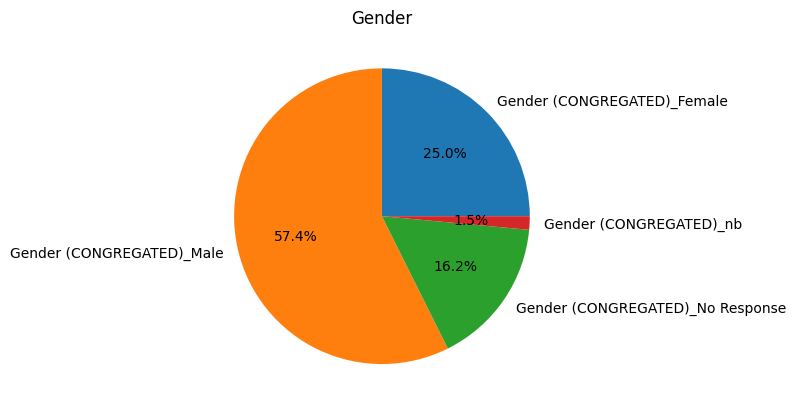

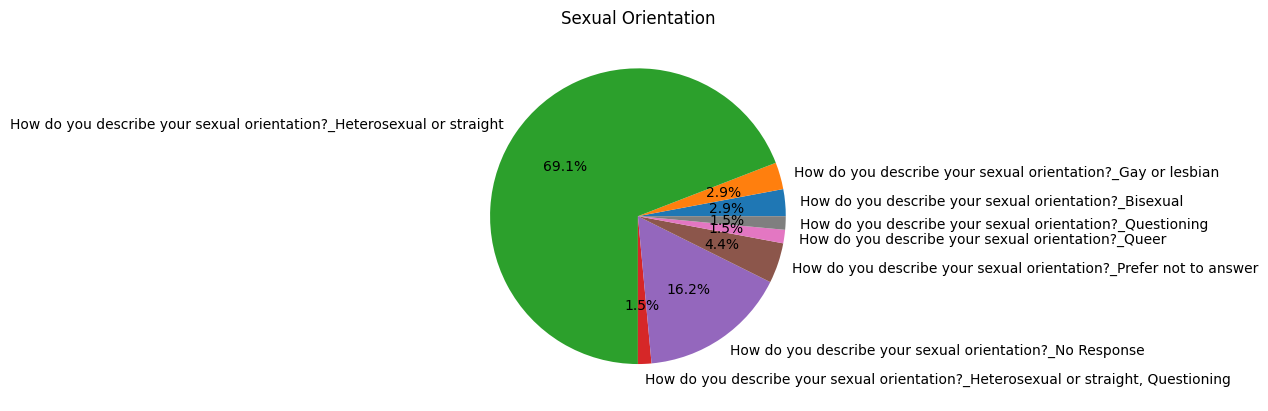

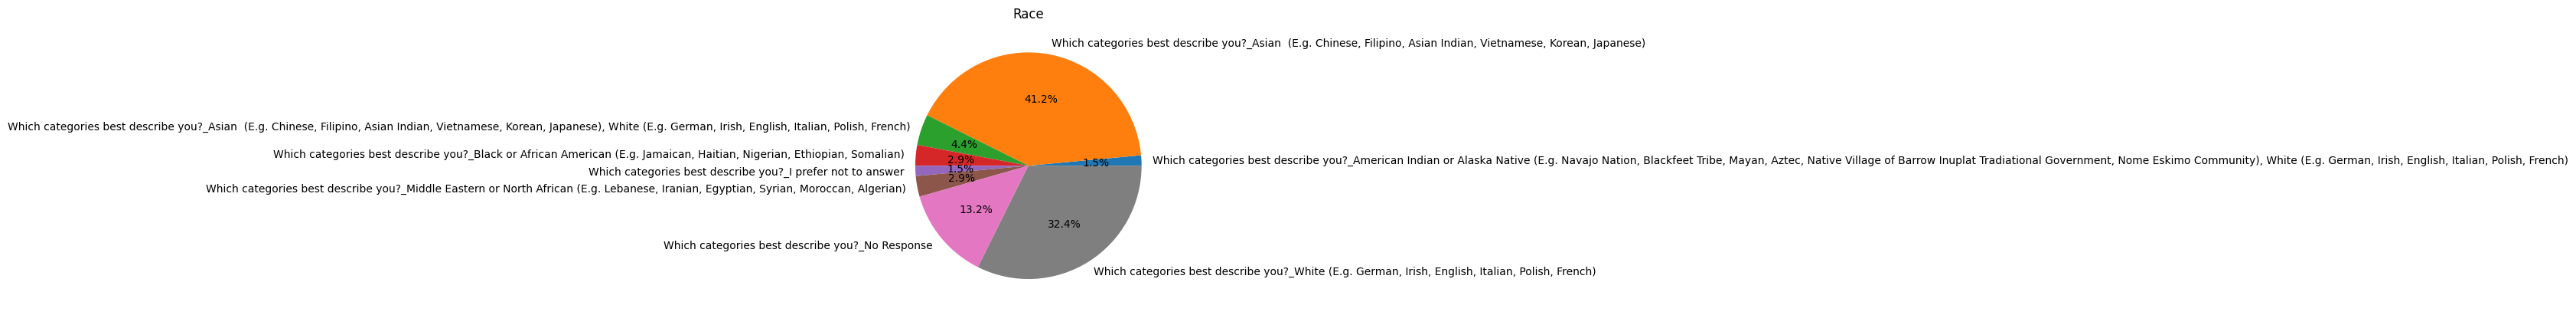

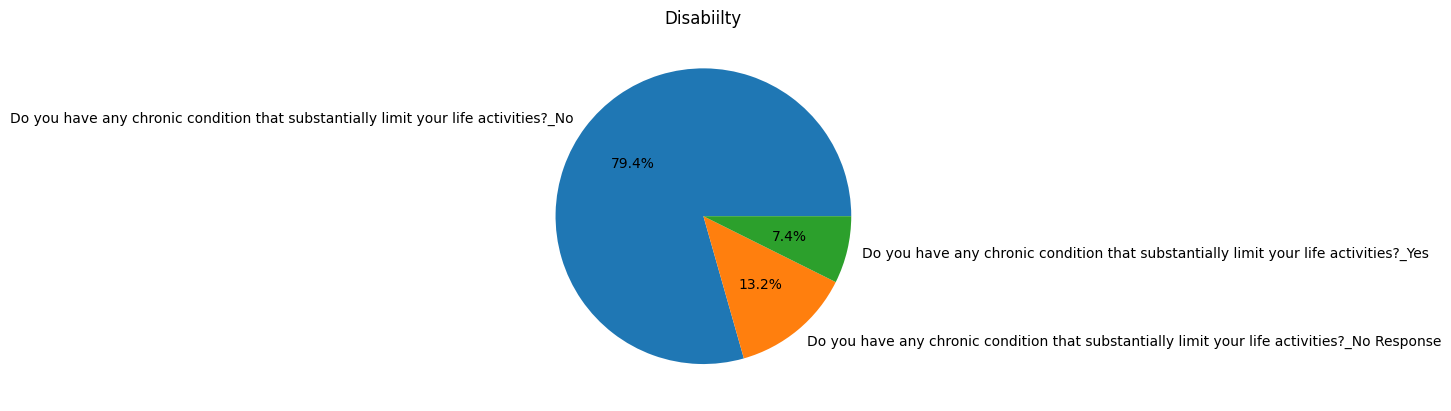

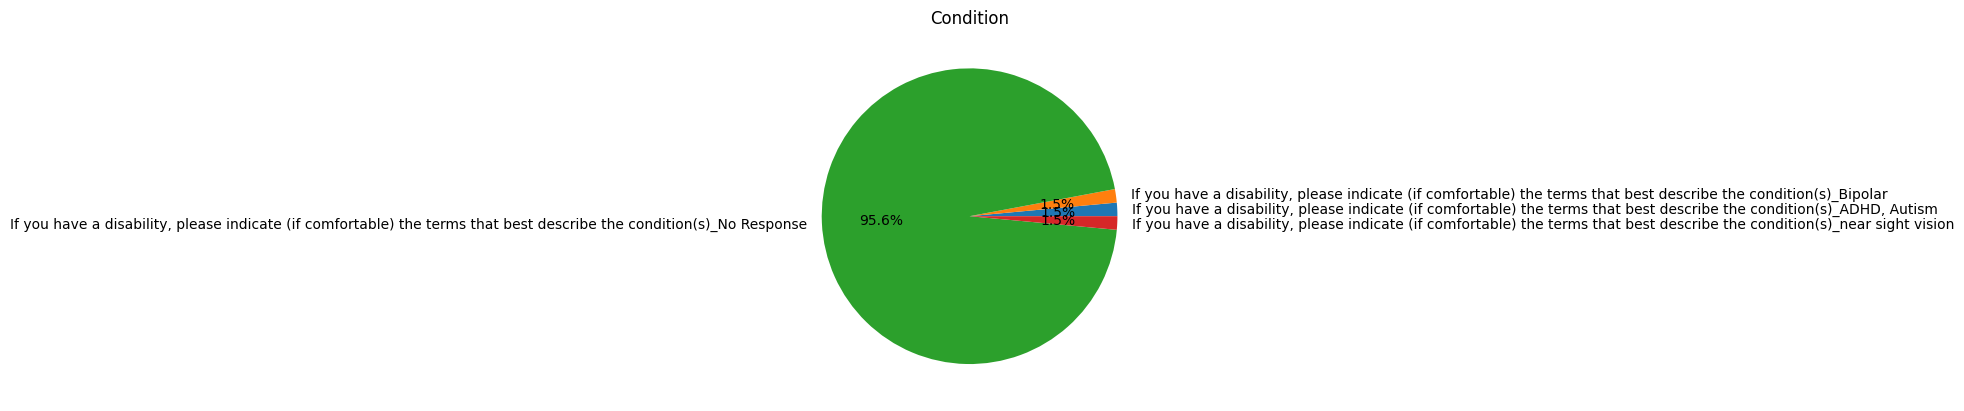

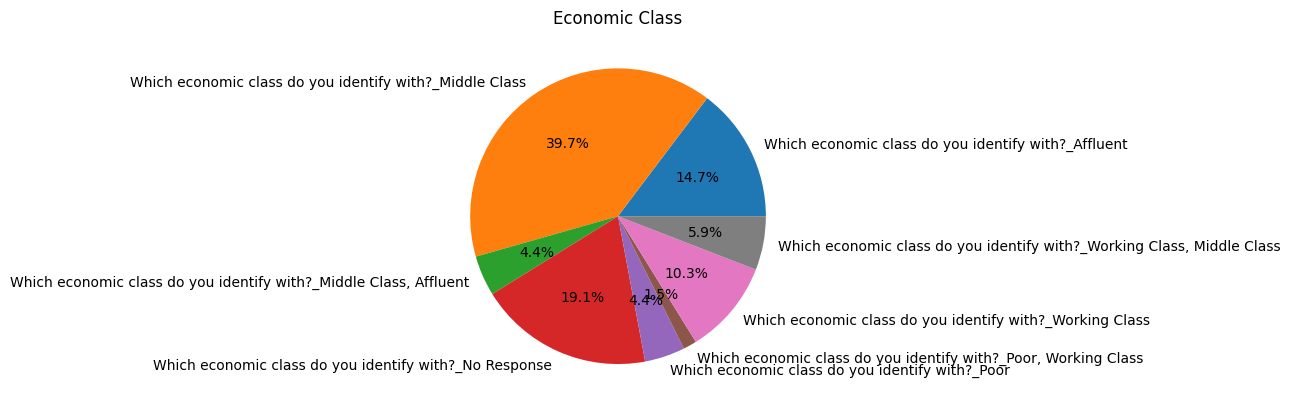

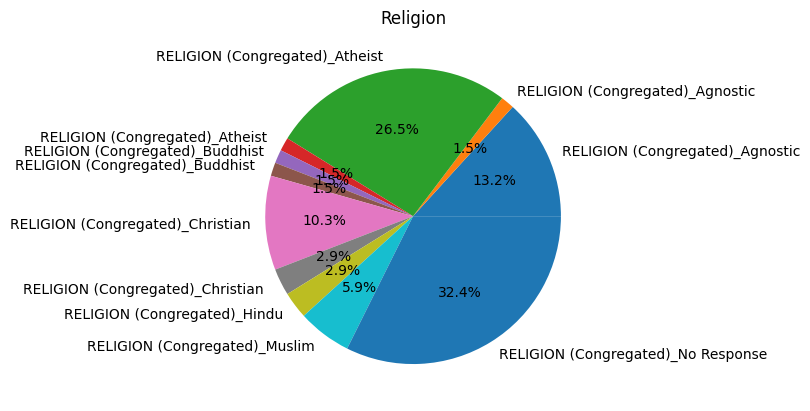

In [11]:
demographics = [gender_data, sex_orient_data, race_data, disability_data,condition_data, economic_data, religion_data]
demographic_title = ['Gender', 'Sexual Orientation', 'Race', 'Disabiilty', 'Condition', 'Economic Class', 'Religion']

for i, dat in enumerate(demographics):
    counts = dat.sum()
    counts = counts[counts > 0]
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.title(demographic_title[i])
    plt.savefig(f"{demographic_title[i].replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

